# compare the GT and the extracted data

## copy the json from all set

In [27]:
import glob
import os
import shutil
# get a list of all *.html in app\static\data\matched
html_files = glob.glob('../app/static/data/matched/matched/*.html')
json_files = [os.path.basename(file[:-5]+".json") for file in html_files ]
json_files = set(json_files)

# get a set of all *.json in ../app/static/data/jsons
json_files_all = glob.glob('../app/static/data/jsons/*.json')
json_files_all = [os.path.basename(file) for file in json_files_all]
json_files_all = set(json_files_all)

# find the intersection of the two sets
json_intersection = json_files.intersection(json_files_all)
assert len(json_intersection) == len(json_files), "All json files are already present in ../app/static/data/jsons"



In [15]:
print("EPC2007C_datasheet_p2f1.json" in json_files_all)
print("EPC2007C_datasheet_p2f1.json" in json_files)
print("EPC2007C_datasheet_p2f1.json" in json_intersection)

True
True
True


In [21]:
# use shutil to copy intersected json files to ../app/static/data/matched/matched/
project_dir = "D:\\workspace\\PowerBrain\\annotation_gt"
for file in json_intersection:
    shutil.copy(os.path.join(project_dir,'app/static/data/jsons/'+file), os.path.join(project_dir,'app/static/data/matched/matched/'+file))
    print("Copied "+file)

Copied EPC2044_datasheet_p2f4.json
Copied EPC7019_datasheet_p3f5.json
Copied EPC2619_datasheet_p2f4.json
Copied epc2055_datasheet_p2f1.json
Copied EPC7007_datasheet_p2f3.json
Copied EPC2020_datasheet_p3f3.json
Copied EPC2221_datasheet_p2f4.json
Copied EPC2023_datasheet_p3f5.json
Copied EPC2070_datasheet_p2f2.json
Copied EPC2007C_datasheet_p3f1.json
Copied EPC2110_datasheet_p3f5.json
Copied EPC2007C_datasheet_p2f1.json
Copied EPC7004_datasheet_p3f5.json
Copied EPC2214_datasheet_p3f4.json
Copied EPC2216_datasheet_p2f3.json
Copied EPC2111_datasheet_p3f3.json
Copied EPC2040_datasheet_p3f1.json
Copied EPC2308_datasheet_p2f4.json
Copied EPC2020_datasheet_p4f1.json
Copied EPC2105_datasheet_p4f1.json
Copied EPC2308_datasheet_p2f1.json
Copied epc2055_datasheet_p3f4.json
Copied EPC2039_datasheet_p3f1.json
Copied EPC2619_datasheet_p3f1.json
Copied EPC2215_datasheet_p2f2.json
Copied EPC2216_datasheet_p2f1.json
Copied EPC7003_datasheet_p2f2.json
Copied EPC2029_datasheet_p2f2.json
Copied EPC2045_dat

## compare the GT and the extracted data 

### data prepration 

In [32]:
# extract data from json file
import json
import re
import os
import shutil
import glob
import numpy as np

# evaluate the interpolation result from a ground truth and an extracted data
from scipy.interpolate import interp1d
from scipy.spatial import distance
import tqdm





In [30]:
# extract ground truth data from json files to npz files
json_intersection = glob.glob('../app/static/data/matched/matched/*.json')
json_intersection = [os.path.basename(file) for file in json_intersection]

for file in json_intersection:
    with open('../app/static/data/matched/matched/'+file, 'r') as f:
        data = json.load(f)
    result = []
    for item in data['data']:
        x = item['x']
        y = item['y']
        assert len(x) == len(y), "x and y have different lengths"
        arr = np.array([x,y],dtype=np.float64).T
        result.append(arr)
    np.savez("../app/static/data/matched/matched/"+file[:-5]+"_gt.npz",*result)



### compare data

In [45]:
def intersection(gt_arr, extract_arr):
    # find the intersection of the two arrays in terms of range of x , keep only intersection points only for gt_arr
    # make sure that the range of x for gt_arr is within the range of x for extract_arr
    x_min = max(gt_arr[0,0], extract_arr[0,0])
    x_max = min(gt_arr[-1,0], extract_arr[-1,0])
    gt_arr = gt_arr[(gt_arr[:,0] >= x_min) & (gt_arr[:,0] <= x_max)]

    # if intersection is empty, return None
    if len(gt_arr) == 0:
        return None, extract_arr
    return gt_arr, extract_arr

def evaluate(gt_arr, extract_arr,intersectionCheck=True,scaler=None):
    # evalueate the interpolation result from a ground truth and an extracted data
    # loss : \sum_{i=0}^{N}\frac{1}{N}\frac{|\hat{y}^i-y_{gt}^i|}{\min{\vec{y}_{gt}}-\max{\vec{y}_{gt}}}

    if intersectionCheck:
        # use the intersection function to find the intersection of the two arrays
        gt_arr_intersected, extract_arr = intersection(gt_arr, extract_arr)
        if gt_arr_intersected is None:
            return np.inf
    else:
        gt_arr_intersected = gt_arr
    # if gt_arr_intersected is too small or extract_arr is empty, return Inf, as the evaluation is not possible
    if len(gt_arr_intersected) <= 3 or len(extract_arr) == 0:
        return np.inf
    
    # interpolate the gt data on extract_arr x values
    f = interp1d(extract_arr[:,0], extract_arr[:,1], kind='linear', fill_value='extrapolate')

    # evaluate the interpolation result based on means of absolute differences
    if not scaler:
        scaler = np.max(gt_arr_intersected[:,1])-np.min(gt_arr_intersected[:,1])
    else:
        scaler = scaler
    gt_arr_interp = f(gt_arr_intersected[:,0])
    loss = np.mean(np.abs(gt_arr_intersected[:,1]-gt_arr_interp)/(scaler))
    # calculate the loss 

    return loss



In [36]:
# extracted GT data from json file
gt_arr_list_file = np.load("test_EPC2007C_datasheet_p2f1.npz")
gt_arr_list = []
for i in range(len(gt_arr_list_file.files)):
    gt_arr_list.append(gt_arr_list_file[gt_arr_list_file.files[i]]) 
gt_arr_list_file.close()

# extract powerbrain data from npz file
extract_arr_list_file = np.load("..\\app\\static\\data\\matched\\matched\\EPC2007C_datasheet_p2f1.npz")
extract_arr_list = []
for i in range(len(extract_arr_list_file.files)):
    extract_arr_list.append(extract_arr_list_file[extract_arr_list_file.files[i]])
extract_arr_list_file.close()

In [37]:
loss_matrix = np.zeros((len(gt_arr_list),len(extract_arr_list)))
# the dimension of the loss matrix is len(gt_arr_list) x len(extract_arr_list)
# number of ground truth arrays

scaler = 0
for i in range(len(gt_arr_list)):
    scaler = max(scaler, np.max(gt_arr_list[i][:,1])-np.min(gt_arr_list[i][:,1]))

for i in range(len(gt_arr_list)):  
    for j in range(len(extract_arr_list)):
        loss_matrix[i,j] = evaluate(gt_arr_list[i], extract_arr_list[j],scaler=scaler)

losses = np.min(loss_matrix,axis=1) # get the minimum loss for each ground truth array
mean_loss = np.mean(losses,axis=0) # get the mean of the minimum losses


with open("mean_relative_abs_loss_record.txt","w") as f:
    f.write(f"EPC2007C_datasheet_p2f1\t{mean_loss}\n")

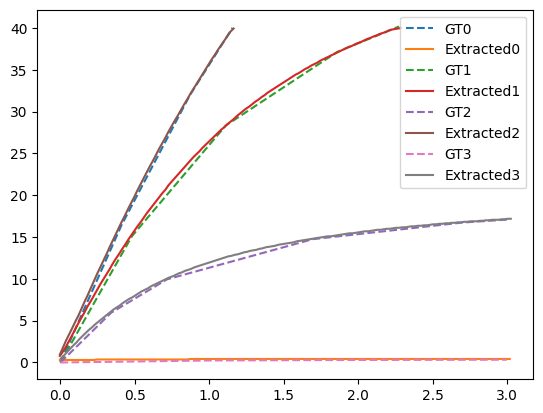

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# plot the gt_arr_list.files
for i in range(len(gt_arr_list)):
    ax.plot(gt_arr_list[i][:,0],gt_arr_list[i][:,1],label="GT"+str(i),linestyle='dashed')
    ax.plot(extract_arr_list[i][:,0],extract_arr_list[i][:,1],label="Extracted"+str(i))
ax.legend()

In [14]:
print(gt_arr_list.files[0])
print(gt_arr_list[gt_arr_list.files[0]].shape)
arr_0 = gt_arr_list[gt_arr_list.files[0]]
print(arr_0)


arr_0
(4, 2)
[[ 1.30934087e-04 -8.84998086e-04]
 [ 4.09299957e-01  1.63888012e+01]
 [ 8.69887888e-01  3.19910783e+01]
 [ 1.15581520e+00  4.00280568e+01]]


In [46]:
# for every json file in the matched folder, evaluate the interpolation result
# and save the result in a txt file
npz_files_dir = "../app/static/data/matched/matched/"
json_intersection = glob.glob(npz_files_dir+"*.json")
json_intersection = [os.path.basename(file) for file in json_intersection]
gt_arr_list_files = [file[:-5]+"_gt.npz" for file in json_intersection]
extract_arr_list_files = [file[:-5]+".npz" for file in json_intersection]
assert len(gt_arr_list_files) == len(extract_arr_list_files), "gt_arr_list_files and extract_arr_list_files have different lengths"


def mean_realative_abs_loss(gt_arr_list, extract_arr_list):
    loss_matrix = np.zeros((len(gt_arr_list),len(extract_arr_list)))
    scaler = 0
    for i in range(len(gt_arr_list)):
        scaler = max(scaler, np.max(gt_arr_list[i][:,1])-np.min(gt_arr_list[i][:,1]))

    for i in range(len(gt_arr_list)):
        for j in range(len(extract_arr_list)):
            loss_matrix[i,j] = evaluate(gt_arr_list[i], extract_arr_list[j],scaler=scaler)
    
    losses = np.min(loss_matrix,axis=1)
    mean_loss = np.mean(losses,axis=0)
    return mean_loss

for gt_arr_list_filename, extract_arr_list_filename in tqdm.tqdm(zip(gt_arr_list_files,extract_arr_list_files)):
    # extracted GT data from npz file
    gt_arr_list_file = np.load(npz_files_dir+gt_arr_list_filename)
    gt_arr_list = []
    for i in range(len(gt_arr_list_file.files)):
        gt_arr_list.append(gt_arr_list_file[gt_arr_list_file.files[i]])
    gt_arr_list_file.close()

    # extract powerbrain data from npz file
    extract_arr_list_file = np.load(npz_files_dir+extract_arr_list_filename)
    extract_arr_list = []
    for i in range(len(extract_arr_list_file.files)):
        extract_arr_list.append(extract_arr_list_file[extract_arr_list_file.files[i]])
    extract_arr_list_file.close()

    # evaluate the mean relative absolute loss
    mean_loss = mean_realative_abs_loss(gt_arr_list, extract_arr_list)
    with open("mean_relative_abs_loss_record.txt","a") as f:
        f.write(f"{gt_arr_list_filename[:-7]}\t{mean_loss}\n")
    


170it [00:06, 25.69it/s]


### postprocess of results

In [47]:
# read the mean_relative_abs_loss_record.txt file calculate the mean of the mean relative absolute loss
with open("mean_relative_abs_loss_record.txt","r") as f:
    lines = f.readlines()
    mean_losses = []
    for line in lines:
        mean_losses.append(float(line.split("\t")[1]))
    mean_losses = np.array(mean_losses)
    mean_mean_loss = np.mean(mean_losses)

inf


In [48]:
# remove inf values from the mean_losses
mean_losses = mean_losses[mean_losses != np.inf]
mean_mean_loss = np.mean(mean_losses)

In [49]:
print(mean_mean_loss)

0.018224695945923054
